This notebook provides all the details for reproducing the visualizations in the results of two papers mentioned below.
<ol>
<li> <H4> Sude Tavassoli and Katharina A. Zweig, <i style=color:blue>"Analyzing Multiple Rankings of Influential Nodes in Multiplex Networks."</i> In the proceedings of fifth International Workshop on Complex Networks and their Applications, pp. 135-146. Springer International Publishing, 2016. </H4> </li>
<li> <H4> Sude Tavassoli and Katharina A. Zweig, <i style=color:blue>"Most central or least central? How much modeling decisions influence a node's centrality ranking in multiplex networks"</i>, In the proceedings of the third European Network Intelligence Conference, pp. 25-32, 2016. </H4> </li>
</ol>

<h3 style="color:purple"> First all the required packages are added.</h3>

In [ ]:
libs <- c('plyr','openxlsx','gridExtra','ggplot2','e1071','reshape2')
lapply(libs, require, character.only = T)
options(stringsAsFactors = TRUE)

<h3 style=color:purple> Set the directory to where all the files containing rankings of nodes produced using the proposed method in ref.1</h3>
The used data set in the paper is obtained from <a>https://snap.stanford.edu/data/higgs-twitter.html</a>


In [ ]:
setwd("//Files/")
files<-list.files(pattern="Ranking_3cent_.*.xlsx")
name<-paste("Node",c(1:127))
nodes<-c(1:127)
# we want to measure the differences of rankings obtained for each node
max.agg.norm<-data.frame(matrix(0,length(nodes),2))
colnames(max.agg.norm)<-c("Delta_Layers","Delta_Agg")
Diff.maxmin<-data.frame(matrix(0,length(nodes),11))
colnames(Diff.maxmin)<-c(-20,-10,-7,-5,-2,0,2,5,7,10,20)

In [ ]:
for (i in 1:length(nodes)) {
  Rank.allLayers<-data.frame(matrix(0,3,11))
  row.names(Rank.allLayers)<-c("Mention","Reply","Retweet")
  colnames(Rank.allLayers)<-c(-20,-10,-7,-5,-2,0,2,5,7,10,20)
  Diff.maxmin.Layer<-data.frame(0,0,0)
  for (f in 1:length(files)) {
    Rank<-read.xlsx(files[f],1,rowNames=F)
    Rank.allLayers[f,]<-Rank[i,2:12] 
    Diff.maxmin.Layer[f]<-ifelse(which.max(Rank.allLayers[f,])>5,(max(Rank.allLayers[f,])-min(Rank.allLayers[f,])),-(max(Rank.allLayers[f,])-min(Rank.allLayers[f,]))) 
    
  }
  max.agg.norm[i,2]<-ifelse(sum(count(Diff.maxmin.Layer[Diff.maxmin.Layer<0])$freq)>=2,
                            -abs(Diff.maxmin.Layer[which.max( abs(Diff.maxmin.Layer) )]),
                            abs(Diff.maxmin.Layer[which.max( abs(Diff.maxmin.Layer) )]))
  for(j in 1:ncol(Rank.allLayers))
  {
    Diff.maxmin[i,j]<-max(Rank.allLayers[,j])-min(Rank.allLayers[,j])    
  }
  max.agg.norm[i,1]<-ifelse(which.max(Diff.maxmin[i,])>=5, max(Diff.maxmin[i,]),-(max(Diff.maxmin[i,])))
}

#lets see what we have so far as the result of two measures
head(max.agg.norm)


<h3 style=color:purple> Categorize the nodes using Cmeans clustering based on their rankings obatined using two measures of &Delta;	 Agg and &Delta; Layers</h3>


In [30]:
agg.layers.norm<-data.frame(layers=(max.agg.norm[,1]-min(max.agg.norm[,1]))/(max(max.agg.norm[,1])-min(max.agg.norm[,1])),
                            agg=(max.agg.norm[,2]-min(max.agg.norm[,2]))/(max(max.agg.norm[,2])-min(max.agg.norm[,2])))
kcenters<-t(data.frame(center1=c(quantile(agg.layers.norm[,1])[4],quantile(agg.layers.norm[,2])[4]),
                       center2=c(quantile(agg.layers.norm[,1])[4],quantile(agg.layers.norm[,2])[2]),
                       center3=c(quantile(agg.layers.norm[,1])[2],quantile(agg.layers.norm[,2])[2]),
                       center4=c(quantile(agg.layers.norm[,1])[2],quantile(agg.layers.norm[,2])[4])))

cl<-cmeans(agg.layers.norm,kcenters,10,verbose=T,method="cmeans",m=2)
transparency<-apply(cl$membership,1,max)


Iteration:   1, Error:  0.0143104530
Iteration:   2, Error:  0.0140333960
Iteration:   3, Error:  0.0139942015
Iteration:   4, Error:  0.0139862369
Iteration:   5, Error:  0.0139841531
Iteration:   6, Error:  0.0139835110
Iteration:   7, Error:  0.0139832946
Iteration:   8, Error:  0.0139832184
Iteration:   9, Error:  0.0139831910
Iteration:  10, Error:  0.0139831811


In [31]:
norm.trans<-(0.5*(transparency-min(transparency))/(max(transparency)-min(transparency)))+0.5
agg.layers.norm.df<-data.frame(agg.layers.norm,Cluster=cl$cluster,Name=name,Alpha=norm.trans)
centers<-as.data.frame(cl$centers)
head(agg.layers.norm.df)

layers,agg,Cluster,Name,Alpha
0.22321429,0.8322981,4,Node 1,0.9906775
0.80803571,0.1366460,2,Node 2,0.9591148
0.83482143,0.3291925,2,Node 3,0.8532037
0.71428571,0.7142857,1,Node 4,0.9726098
0.72767857,0.0621118,2,Node 5,0.8938500
0.06696429,0.7701863,4,Node 6,0.9089732


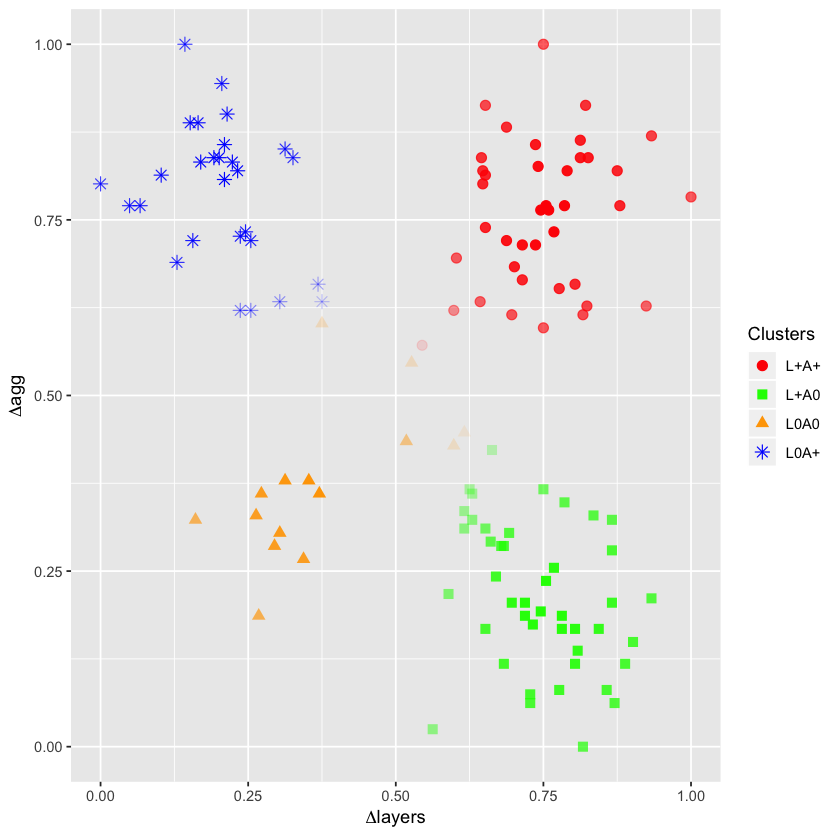

In [32]:
d<-melt(agg.layers.norm.df,id=c("layers","agg","Name","Alpha"))
ggplot(d,aes(x=layers,y=agg,colour=factor(value),shape=factor(value),label=Name))+ geom_point(aes(alpha=Alpha),size=2.5)+xlab(expression(paste(Delta,"layers")))+ylab(expression(paste(Delta,"agg")))+
scale_color_manual(name="Clusters",labels=c("L+A+","L+A0","L0A0","L0A+"),values=c("red","green","orange","blue"))+
  scale_shape_manual(name="Clusters",labels=c("L+A+","L+A0","L0A0","L0A+"),values=c(19,15,17,8))+
  scale_alpha(guide = 'none')

<h3 style=color:purple> Similar to the last experiment, set the directory to where all the files containing rankings of nodes produced using the proposed method in ref.1</h3>
The used data set in the paper includes the interactions between attorneys in a law firm (see the paper for the dataset source).

In [39]:
setwd("//Files/")
files<-list.files(pattern="Ranking_lawfirm.*.xlsx")
name<-paste("Node",c(1:71))
nodes<-c(1:71)
# here we check all maximum, minimum and average differences
max.agg.norm<-data.frame(matrix(0,length(nodes),2))
colnames(max.agg.norm)<-c("Delta_Layers","Delta_Agg")
min.agg.norm<-data.frame(matrix(0,length(nodes),2))
colnames(min.agg.norm)<-c("Delta_Layers","Delta_Agg")
avg.agg.norm<-data.frame(matrix(0,length(nodes),2))
colnames(avg.agg.norm)<-c("Delta_Layers","Delta_Agg")

In [40]:
Diff.maxmin<-data.frame(matrix(0,length(nodes),11))
colnames(Diff.maxmin)<-c(-20,-10,-7,-5,-2,0,2,5,7,10,20)
for (i in 1:length(nodes)) {
  Rank.allLayers<-data.frame(matrix(0,3,11))
  row.names(Rank.allLayers)<-c("Advice","Coworker","Friend")
  colnames(Rank.allLayers)<-c(-20,-10,-7,-5,-2,0,2,5,7,10,20)
  Diff.maxmin.Layer<-data.frame(0,0,0)
  for (f in 1:length(files)) {
    Rank<-read.xlsx(files[f],1,rowNames=F)
    Rank.allLayers[f,]<-Rank[i,2:12] 
    Diff.maxmin.Layer[f]<-abs(max(Rank.allLayers[f,])-min(Rank.allLayers[f,]))
    
  }
  max.agg.norm[i,2]<-max(abs(Diff.maxmin.Layer))
  min.agg.norm[i,2]<-min(abs(Diff.maxmin.Layer))
  avg.agg.norm[i,2]<-mean(as.numeric(Diff.maxmin.Layer))
  for(j in 1:ncol(Rank.allLayers))
  {
    Diff.maxmin[i,j]<-abs(max(Rank.allLayers[,j])-min(Rank.allLayers[,j]))
    
  }
  
  max.agg.norm[i,1]<- max(Diff.maxmin[i,])
    min.agg.norm[i,1]<- min(Diff.maxmin[i,])
    avg.agg.norm[i,1]<-mean(as.numeric(Diff.maxmin[i,]))
}

head(max.agg.norm)

Delta_Layers,Delta_Agg
50,52
29,23
56,59
13,13
24,32
57,26


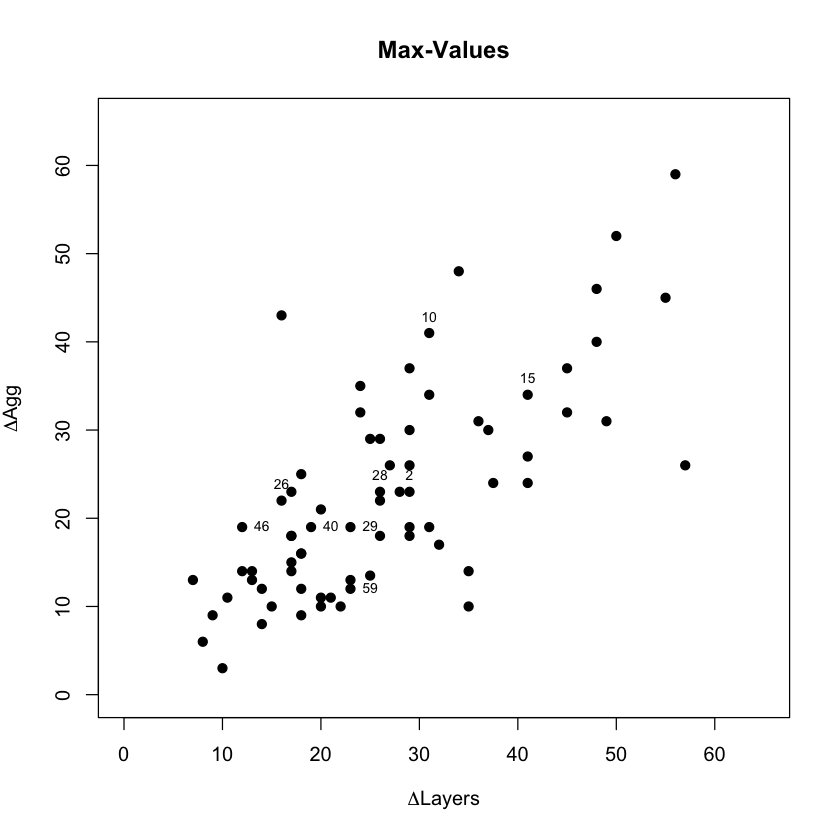

In [41]:
#plot only maximum differences for all nodes, visualizing the rest can be done by simply put the min.agg.norm in the following lines

plot(max.agg.norm,pch=19,ylab=expression(paste(Delta,"Agg")),xlim=c(0,65),ylim=c(0,65),xlab=expression(paste(Delta,"Layers")),main="Max-Values")
name<-as.character(c(2,10,15,26,28,29,40,46,59,92,96,103))
text(max.agg.norm[as.numeric(name),],name,cex=0.7,pos=c(rep(3,5),rep(4,5),rep(2,5),rep(1,5)))

<h3 style=color:purple>Visualize the categories of nodes using cmeans clustering with respect to their rankings</h3>

In [73]:
selectednodes<-c(1,3,4,8,17,24,26,27,56,57,65,66)
agg.layers.norm<-data.frame(layers=(max.agg.norm[,1]-min(max.agg.norm[,1]))/(max(max.agg.norm[,1])-min(max.agg.norm[,1])),
                             agg=(max.agg.norm[,2]-min(max.agg.norm[,2]))/(max(max.agg.norm[,2])-min(max.agg.norm[,2])))
 kcenters<-t(data.frame(center1=c(quantile(agg.layers.norm[,1])[4],quantile(agg.layers.norm[,2])[4]),
                       center2=c(quantile(agg.layers.norm[,1])[4],quantile(agg.layers.norm[,2])[2]),
                        center3=c(quantile(agg.layers.norm[,1])[2],quantile(agg.layers.norm[,2])[2]),
                        center4=c(quantile(agg.layers.norm[,1])[2],quantile(agg.layers.norm[,2])[4])))
cl<-cmeans(agg.layers.norm,kcenters,10,verbose=T,method="cmeans",m=2)
 transparency<-apply(cl$membership,1,max)
 agg.layers.norm.df<-data.frame(agg.layers.norm,Cluster=cl$cluster,Alpha=transparency)
 centers<-as.data.frame(cl$centers)
d<-melt(agg.layers.norm.df,id=c("layers","agg","Name","Alpha"))
ggplot(d,aes(x=layers,y=agg,colour=factor(value),shape=factor(value),label=Name))+ geom_point(aes(alpha=Alpha),size=2.4)+
   xlab(expression(paste(Delta,"layers")))+ylab(expression(paste(Delta,"agg")))+
   scale_color_manual(name="Clusters",labels=c("L+A+","L+A0","L0A0","L0A+"),values=c("red","green","orange","blue"))+
   scale_shape_manual(name="Clusters",labels=c("L+A+","L+A0","L0A0","L0A+"),values=c(19,15,17,8))+
   annotate("point",x=centers$V1,y=centers$V2,shape=4,colour="black")+geom_text(data=d[selectednodes,],aes(label=Name),vjust=1.2,show.legend=F)+
   scale_alpha(guide = 'none')
  

Iteration:   1, Error:  0.0173035682
Iteration:   2, Error:  0.0152100940
Iteration:   3, Error:  0.0140233815
Iteration:   4, Error:  0.0135012012
Iteration:   5, Error:  0.0132892627
Iteration:   6, Error:  0.0131921576
Iteration:   7, Error:  0.0131428227
Iteration:   8, Error:  0.0131158219
Iteration:   9, Error:  0.0131001551
Iteration:  10, Error:  0.0130906347


ERROR: Error in data.frame(agg.layers.norm, Cluster = cl$cluster, Name = name, : arguments imply differing number of rows: 71, 12


In [11]:

kcenters<-t(data.frame(center1=c(quantile(agg.layers.norm[,1])[4],quantile(agg.layers.norm[,2])[4]),
                       center2=c(quantile(agg.layers.norm[,1])[4],quantile(agg.layers.norm[,2])[2]),
                       center3=c(quantile(agg.layers.norm[,1])[2],quantile(agg.layers.norm[,2])[2]),
                       center4=c(quantile(agg.layers.norm[,1])[2],quantile(agg.layers.norm[,2])[4])))

cl<-cmeans(agg.layers.norm,kcenters,10,verbose=T,method="cmeans",m=2)
transparency<-apply(cl$membership,1,max)

Iteration:   1, Error:  0.0143104530
Iteration:   2, Error:  0.0140333960
Iteration:   3, Error:  0.0139942015
Iteration:   4, Error:  0.0139862369
Iteration:   5, Error:  0.0139841531
Iteration:   6, Error:  0.0139835110
Iteration:   7, Error:  0.0139832946
Iteration:   8, Error:  0.0139832184
Iteration:   9, Error:  0.0139831910
Iteration:  10, Error:  0.0139831811


[1] 0.9874400 0.9459430 0.8066965 0.9636856 0.8601362 0.8800194 0.6993156
  [8] 0.8582296 0.8624769 0.6247729 0.9152212 0.8364486 0.8875969 0.8094553
 [15] 0.9171130 0.8489791 0.7698826 0.9876425 0.9823377 0.4611056 0.7940747
 [22] 0.8605225 0.8457969 0.9311033 0.9899077 0.4042958 0.9154105 0.8838147
 [29] 0.8134856 0.7954787 0.8213723 0.7477981 0.9973716 0.8575103 0.8350706
 [36] 0.5386596 0.9871078 0.9392282 0.9987825 0.8680104 0.8838735 0.9701950
 [43] 0.8625008 0.9996968 0.5698751 0.6042194 0.8749064 0.9955706 0.9740143
 [50] 0.9908889 0.8812849 0.8900391 0.8685830 0.3423224 0.7395343 0.7955215
 [57] 0.8801444 0.8845643 0.4128397 0.9933164 0.7214963 0.6170575 0.9896706
 [64] 0.7686270 0.7835964 0.4978359 0.9849330 0.5567912 0.9849730 0.7263845
 [71] 0.7351104 0.5939265 0.8883588 0.9759453 0.8473993 0.9466676 0.9896110
 [78] 0.8885785 0.4261050 0.3555324 0.8632580 0.9819728 0.8802979 0.3866093
 [85] 0.9399086 0.9361844 0.8751983 0.8966749 0.9868172 0.9303786 0.9127146
 [92] 0.5990920 0.7843710 0.9312552 0.7201358 0.7326468 0.9987478 0.9628556
 [99] 0.7907433 0.8396807 0.9897544 0.8764584 0.8599154 0.9990019 0.7185003
[106] 0.9722049 0.9069138 0.9314134 0.9164946 0.9348077 0.9262293 0.9445016
[113] 0.5129678 0.8428734 0.9761822 0.9192116 0.6610620 0.9598873 0.5557763
[120] 0.7635025 0.8249529 0.9204693 0.9597460 0.9180084 0.9061868 0.6094004
[127] 0.6947468

In [12]:
norm.trans<-(0.5*(transparency-min(transparency))/(max(transparency)-min(transparency)))+0.5

agg.layers.norm.df<-data.frame(agg.layers.norm,Cluster=cl$cluster,Alpha=norm.trans)
centers<-as.data.frame(cl$centers)
head(agg.layers.norm.df)


layers,agg,Cluster,Alpha
0.22321429,0.8322981,4,0.9906775
0.80803571,0.1366460,2,0.9591148
0.83482143,0.3291925,2,0.8532037
0.71428571,0.7142857,1,0.9726098
0.72767857,0.0621118,2,0.8938500
0.06696429,0.7701863,4,0.9089732


layers,agg,Alpha,variable,value
0.22321429,0.8322981,0.9906775,Cluster,4
0.80803571,0.1366460,0.9591148,Cluster,2
0.83482143,0.3291925,0.8532037,Cluster,2
0.71428571,0.7142857,0.9726098,Cluster,1
0.72767857,0.0621118,0.8938500,Cluster,2
0.06696429,0.7701863,0.9089732,Cluster,4
0.64285714,0.6335404,0.7715296,Cluster,1
0.68750000,0.8819876,0.8923999,Cluster,1
0.90178571,0.1490683,0.8956303,Cluster,2
0.62946429,0.3229814,0.7148323,Cluster,2


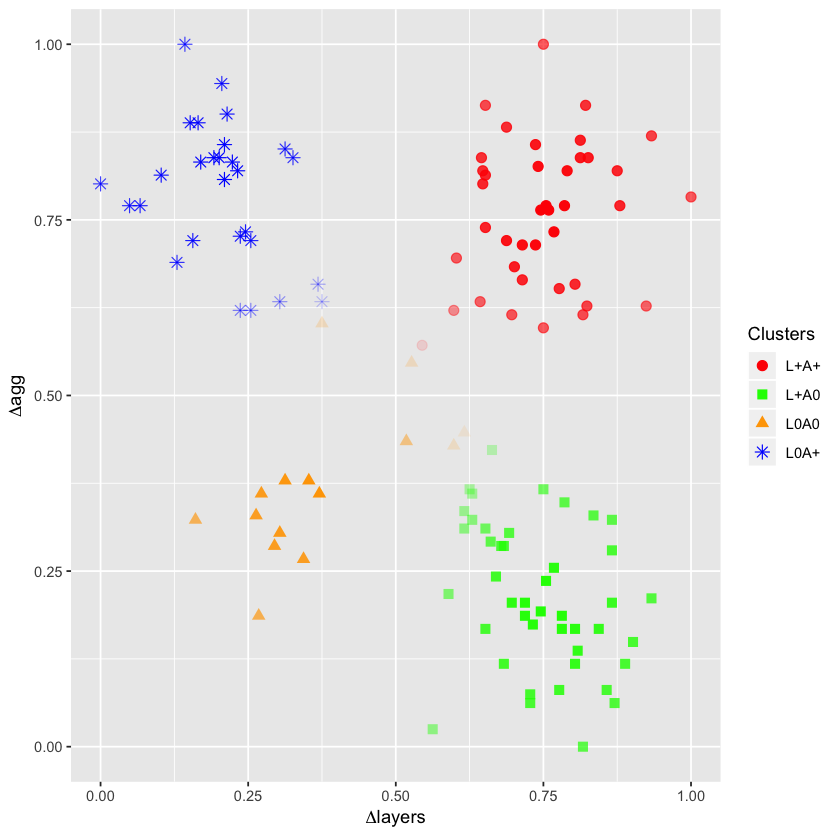

In [13]:
d<-melt(agg.layers.norm.df,id=c("layers","agg","Alpha"))
ggplot(d,aes(x=layers,y=agg,colour=factor(value),shape=factor(value)))+ geom_point(aes(alpha=Alpha),size=2.5)+xlab(expression(paste(Delta,"layers")))+ylab(expression(paste(Delta,"agg")))+
scale_color_manual(name="Clusters",labels=c("L+A+","L+A0","L0A0","L0A+"),values=c("red","green","orange","blue"))+
  scale_shape_manual(name="Clusters",labels=c("L+A+","L+A0","L0A0","L0A+"),values=c(19,15,17,8))+
  scale_alpha(guide = 'none')

<h3 style=color:purple> In the following, we are going to visualize the ranking differences for all nodes in an airline multiplex-network including three layers (please see the paper[2] for the detail of the used data)</h3>

The sensitivity analysis is conducted over taking several normalization methods versus over taking different aggregation strategies


In [44]:
setwd("//Files/")

files<-list.files(pattern="Ranking_method.*.xlsx")
Rank_1<-read.xlsx(files[1],1,rowNames=F)
Rank_2<-read.xlsx(files[2],1,rowNames=F)
Rank_3<-read.xlsx(files[3],1,rowNames=F)
Rank_4<-read.xlsx(files[4],1,rowNames=F)

name<-read.xlsx(files[1],1)[,1]
max.agg.norm<-data.frame(matrix(0,20,2))

In [45]:
for (i in 1:nrow(Rank_1)){
  max.agg.norm[i,1]<-max((abs(max(Rank_1[i,2:ncol(Rank_1)]-min(Rank_1[i,2:ncol(Rank_1)])))),
                        (abs(max(Rank_2[i,2:ncol(Rank_1)])-min(Rank_2[i,2:ncol(Rank_1)]))),
                        (abs(max(Rank_3[i,2:ncol(Rank_1)])-min(Rank_3[i,2:ncol(Rank_1)]))),
                        (abs(max(Rank_4[i,2:ncol(Rank_1)])-min(Rank_4[i,2:ncol(Rank_1)]))))
    max.norm<- data.frame(matrix(0,1,11))
  for(j in 2:ncol(Rank_1))  
  { 
    max.norm[j]<-abs(max(Rank_1[i,j],Rank_2[i,j],
                           Rank_3[i,j],Rank_4[i,j])-min(Rank_1[i,j],Rank_2[i,j],Rank_3[i,j],Rank_4[i,j]))
  
  }
    max.agg.norm[i,2]<-max(max.norm)
}

In [46]:
#The following function produces multiple colors for chosen nodes
mycol<-function(x,y){
  result<-list()
  for (i in 1:length(x)) {
    if (x[i]>max(x)/2 & y[i] > max(y)/2) result[[i]]="red"
    else if (x[i]>=max(x)/2 & y[i]<= max(y)/2) result[[i]]="green"
    else if (x[i]<max(x)/2 & y[i]>= max(y)/2) result[[i]]="blue"
    else if (x[i]<max(x)/2 & y[i]< max(y)/2) result[[i]]="purple"
    else result[[i]]="none"
  }
  unlist(result)
}

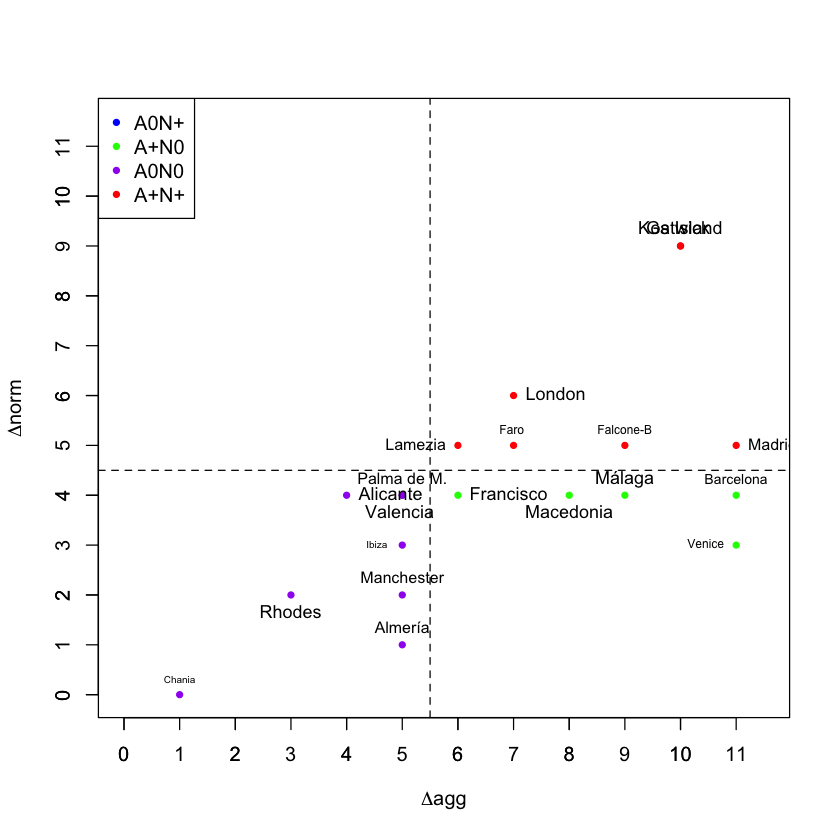

In [51]:
plot(max.agg.norm[,1],max.agg.norm[,2],xlab=expression(paste(Delta,"agg")),xlim=c(0,11.5),ylim=c(0,11.5),
     ylab=expression(paste(Delta,"norm")),cex=1,col=mycol(max.agg.norm[,1],max.agg.norm[,2]),pch=20)
axis(1,at=c(0:11),labels=c(0:11))
axis(2,at=c(0:11),labels=c(0:11))

#The abbrv. A0N+ means not sensitive to aggregations but to normalizations
legend("topleft", inset=c(0,0),c("A0N+","A+N0","A0N0","A+N+"),pch=c(20,20,20,20),col=c("blue","green","purple","red"))
text(max.agg.norm[,1],max.agg.norm[,2], name, cex= sample(seq(0.5,0.9,0.1),nrow(Rank_1),replace=T), pos=sample(seq(1,4,0.5),nrow(Rank_1),replace=T), col="black")
abline(h = max(max.agg.norm[,2])/2, v = max(max.agg.norm[,1])/2, lty=2)